## Installing Packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

## Data Preprocessing

In [2]:
# Create dataframe
df2018flights = pd.read_csv("./Datasets1/2018.csv")

# Remove op_carrier_fl_num, crs_dep_time, dep_time, wheels_off, wheels_on, cancelled, cancellation_co..., diverted, actual_elapsed_..., air_time, unnamed:27
df2018flights = df2018flights.drop(["OP_CARRIER_FL_NUM", "CRS_DEP_TIME", "DEP_TIME", "WHEELS_OFF", "WHEELS_ON", "CANCELLED", "CANCELLATION_CODE", "DIVERTED", "ACTUAL_ELAPSED_TIME", "AIR_TIME", "Unnamed: 27", "ARR_TIME"], axis= 1)

# Create month column
df2018flights["Month"] = pd.DatetimeIndex(df2018flights["FL_DATE"]).month

# Remove date column
df2018flights = df2018flights.drop(["FL_DATE"], axis= 1)

# Add labeled column
df2018flights["Label"] = np.where(df2018flights["ARR_DELAY"] > 15, 1, 0)

# Remove column use to make label
df2018flights = df2018flights.drop(["ARR_DELAY"], axis= 1)

# Airlines to do not fall in hub and spoke or point to point
notRelId = ['9E', 'EV', 'MQ', 'OH', 'OO', 'YV', 'YX']

# Removing from dataframe
mask = ~df2018flights['OP_CARRIER'].isin(notRelId)

# New dataframe without notRel
df2018flights = df2018flights[mask]

# Dummy encode carrier, destination, and origin columns
df2018flights = pd.get_dummies(df2018flights, columns= ["OP_CARRIER", "ORIGIN", "DEST"])

df2018flights.head()

,DEP_DELAY,TAXI_OUT,TAXI_IN,CRS_ARR_TIME,CRS_ELAPSED_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,...,DEST_TUL,DEST_TUS,DEST_TVC,DEST_TYS,DEST_USA,DEST_VPS,DEST_WRG,DEST_XNA,DEST_YAK,DEST_YNG
0,-5.0,15.0,10.0,1745,268.0,1605.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,-8.0,11.0,7.0,1254,99.0,414.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,-5.0,15.0,5.0,1649,134.0,846.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,6.0,19.0,6.0,1756,190.0,1120.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,20.0,13.0,10.0,922,112.0,723.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Preparing and creating test train split
X = df2018flights.drop(["Label"], axis= 1)
y = df2018flights["Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=69)

## Catboost w/o Probabilities
This section demonstrates the accuracy at which the model can predict a flight being delayed when given binary (delayed or not) values

** Need to do some tuning on the model still **

Confusion matrix:
[[1001780     182]
 [      5  219237]]


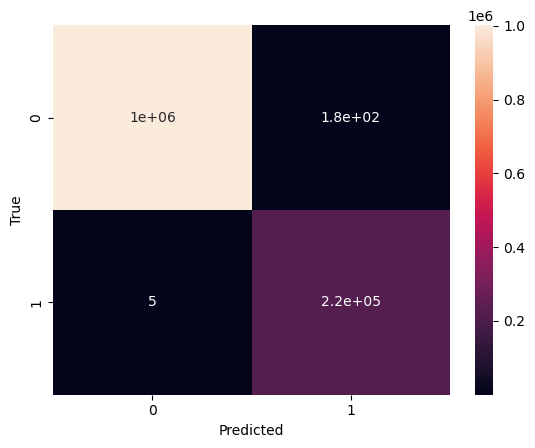

Accuracy: 0.9998468724308142
Precision: 0.9991705367356519
Recall: 0.9999771941507558
F1 Score: 0.999573702699807


In [4]:
## 😸boost ##

# Calculate balance of class weights
import sklearn
weights = sklearn.utils.class_weight.compute_class_weight(class_weight= 'balanced', classes= np.unique(y), y= y)

cb = CatBoostClassifier(iterations=100, random_seed=0, logging_level='Silent', class_weights= weights)
cb.fit(X_train, y_train)

# predict on test set
y_pred = cb.predict(X_test)

# evaluate model performance
conf_mat = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Confusion matrix:")
print(conf_mat)
sns.heatmap(conf_mat, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

In [5]:
# Top predictors of flight being late
importance = cb.get_feature_importance()
cols = X.columns
indices = np.argsort(importance)[::-1]
print("Top Predictors of Upgrade:")
for i in range(X.shape[1]):
    print(f"{cols[indices[i]]}: {importance[indices[i]]}")

Top Predictors of Upgrade:
CARRIER_DELAY: 58.46315608535737
NAS_DELAY: 18.8160586222981
LATE_AIRCRAFT_DELAY: 18.61410218629538
WEATHER_DELAY: 2.1377284895468915
DEP_DELAY: 1.6904267501985226
SECURITY_DELAY: 0.25573735290884697
DISTANCE: 0.00659777446448907
CRS_ARR_TIME: 0.006125488829815387
TAXI_IN: 0.004771931056909208
TAXI_OUT: 0.0030195129046720563
DEST_HNL: 0.0010268984824948213
OP_CARRIER_HA: 0.0008795045076573564
DEST_IND: 7.807915668164934e-05
DEST_ITO: 6.303044933847292e-05
DEST_OGG: 6.14914494882457e-05
DEST_BHM: 5.439739038248406e-05
ORIGIN_SCC: 3.971332827611083e-05
ORIGIN_SAN: 3.693836474316877e-05
ORIGIN_SFB: 2.1541513888763346e-05
DEST_SLC: 9.373563379628642e-06
ORIGIN_RDU: 2.1152004041504393e-06
DEST_YAK: 1.8811161428570997e-06
ORIGIN_KTN: 3.3950965839602547e-07
DEST_RFD: 3.112327703080418e-07
DEST_BUF: 1.4037558928508032e-07
DEST_BUR: 4.42438607064764e-08
CRS_ELAPSED_TIME: 2.4916211334692166e-09
Month: 1.8669545436080618e-09
DEST_RDU: 1.845173532328619e-09
ORIGIN_PIE: 3

<strong>Top predictors of a flight being delayed:</strong>
1. Carrier Delay
2. Air System Delay
3. Late Aircraft Delay
4. Weather Delay
5. Departure Delay

## Catboost with Probabilities
This section gathers the probability at which a flight will be delayed rather than giving it a binary value

** Using the same model as above **

In [6]:
## 😸boost w/o Probabilities##

# Calculate balance of class weights
import sklearn
weights = sklearn.utils.class_weight.compute_class_weight(class_weight= 'balanced', classes= np.unique(y), y= y)

cb = CatBoostClassifier(iterations=100, random_seed=0, logging_level='Silent', class_weights= weights)
cb.fit(X_train, y_train)

# predict probabilities on test set
y_predProba = cb.predict_proba(X_test)[::,1]

print(y_predProba)

[5.99486862e-09 5.90620464e-09 5.99486862e-09 ... 6.69555467e-08
 5.78577065e-09 9.99999954e-01]


## Developing New Flight Dataframe w/ Carrier, Origin, Destination, and ProbabilityDelayed

In [7]:
dfXtest = pd.DataFrame(X_test)
dfXtest.head()

,DEP_DELAY,TAXI_OUT,TAXI_IN,CRS_ARR_TIME,CRS_ELAPSED_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,...,DEST_TUL,DEST_TUS,DEST_TVC,DEST_TYS,DEST_USA,DEST_VPS,DEST_WRG,DEST_XNA,DEST_YAK,DEST_YNG
3585968,-6.0,11.0,8.0,858,118.0,694.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
5311048,-3.0,17.0,5.0,2233,108.0,631.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2280862,-1.0,24.0,7.0,1040,154.0,802.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
812642,35.0,9.0,6.0,2220,210.0,1504.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2119058,-2.0,18.0,4.0,2008,293.0,1931.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Function to pull the locations (origin and destination) from X_test
def pullLocation(df, locType):
    newDict = {}

    df = df.filter(regex= locType).head(250000)

    for index, row in df.iterrows():
        for col in df.columns:
            if row[col] == 1:
                newDict[index] = col.split('_')[1]

    return newDict

# Function to pull the carrier from X_test
def pullCarrier(df):
    newDict = {}

    df = df.filter(regex= 'OP_CARRIER').head(250000)

    for index, row in df.iterrows():
        for col in df.columns:
            if row[col] == 1:
                newDict[index] = col.split('_')[2]

    return newDict

In [9]:
# Creating dataframes with origin location and destination location
dfOrigin = pd.DataFrame(pullLocation(dfXtest, 'ORIGIN').values(), index= pullLocation(dfXtest, 'ORIGIN').keys(), columns= ['Origin'])
dfDest = pd.DataFrame(pullLocation(dfXtest, 'DEST').values(), index= pullLocation(dfXtest, 'DEST').keys(), columns= ['Destination'])

# Creating dataframes with carrier
dfCarrier = pd.DataFrame(pullCarrier(dfXtest).values(), index= pullCarrier(dfXtest).keys(), columns= ["Carrier"])

In [10]:
# Creating dictionary with index as key and probabilities as values
probDict = {val: y_predProba[index] for index, val in enumerate(dfXtest.head(250000).index)}

# Creating dataframe for probabilities
dfProbs = pd.DataFrame(probDict.values(), index= probDict.keys(), columns= ["ProbabilityDelayed"])

In [11]:
# Merging all of these dataframes into one
dfModel = pd.concat([dfCarrier, dfOrigin, dfDest, dfProbs], axis= 1)

In [12]:
dfModel

,Carrier,Origin,Destination,ProbabilityDelayed
3585968,DL,CID,ATL,5.994869e-09
5311048,AA,DFW,BNA,5.906205e-09
2280862,UA,ORD,DFW,5.994869e-09
812642,WN,AUS,EWR,9.994286e-01
2119058,DL,MCO,SLC,5.869239e-09
...,...,...,...,...
5480225,WN,SMF,SNA,5.994463e-09
5695307,AA,ORD,PHX,5.906205e-09
4977957,DL,MSN,MSP,5.996285e-09
927368,WN,TPA,MDW,1.010652e-07


## Performing Aggregations on Flight Routes

In [13]:
dfModel.groupby(['Carrier', 'Origin', 'Destination'])['ProbabilityDelayed'].agg(['count', 'mean'])

count          mean
Carrier Origin Destination                     
AA      ABQ    DFW            104  2.329840e-01
               ORD             28  1.803172e-01
               PHX              6  1.666474e-01
        ALB    CLT             50  1.999126e-01
        ANC    DFW              8  3.749724e-01
...                           ...           ...
WN      TUS    LAX             59  2.199190e-01
               MDW             15  2.256318e-08
               OAK              1  5.909522e-09
               SAN             32  1.874281e-01
               SJC              1  5.912369e-09

[6777 rows x 2 columns]

In [14]:
flightPreds = dfModel.groupby(['Carrier', 'Origin', 'Destination'])['ProbabilityDelayed'].agg(['count', 'mean']).reset_index()
flightPreds = flightPreds.rename(columns= {'count': 'NumFlights', 'mean': 'AvgProbDelayed'})
flightPreds

,Carrier,Origin,Destination,NumFlights,AvgProbDelayed
0,AA,ABQ,DFW,104,2.329840e-01
1,AA,ABQ,ORD,28,1.803172e-01
2,AA,ABQ,PHX,6,1.666474e-01
3,AA,ALB,CLT,50,1.999126e-01
4,AA,ANC,DFW,8,3.749724e-01
...,...,...,...,...,...
6772,WN,TUS,LAX,59,2.199190e-01
6773,WN,TUS,MDW,15,2.256318e-08
6774,WN,TUS,OAK,1,5.909522e-09
6775,WN,TUS,SAN,32,1.874281e-01


In [15]:
# Changing carrier identifiers to names
carrierNamesDict = {'AA': 'American Airlines Inc.', 'AS': 'Alaksa Airlines Inc.', 'B6': 'JetBlue Airways', 'DL': 'Delta Air Lines Inc.', 'F9': 'Frontier Airlines Inc.', 'G4': 'Allegiant Air', 'HA': 'Hawaiian Airlines Inc.', 'NK': 'Spirit Air Lines', 'UA': 'United Air Lines Inc.', 'VX': 'Virgin America', 'WN': 'Southwest Airlines Co.'}
flightPreds['Carrier'] = flightPreds['Carrier'].replace(carrierNamesDict)
flightPreds

,Carrier,Origin,Destination,NumFlights,AvgProbDelayed
0,American Airlines Inc.,ABQ,DFW,104,2.329840e-01
1,American Airlines Inc.,ABQ,ORD,28,1.803172e-01
2,American Airlines Inc.,ABQ,PHX,6,1.666474e-01
3,American Airlines Inc.,ALB,CLT,50,1.999126e-01
4,American Airlines Inc.,ANC,DFW,8,3.749724e-01
...,...,...,...,...,...
6772,Southwest Airlines Co.,TUS,LAX,59,2.199190e-01
6773,Southwest Airlines Co.,TUS,MDW,15,2.256318e-08
6774,Southwest Airlines Co.,TUS,OAK,1,5.909522e-09
6775,Southwest Airlines Co.,TUS,SAN,32,1.874281e-01


In [16]:
# Sorting the dataframe
flightPreds.sort_values(by= ['AvgProbDelayed'], ascending= False)

,Carrier,Origin,Destination,NumFlights,AvgProbDelayed
3891,Allegiant Air,SJU,PIT,1,1.000000e+00
3165,Frontier Airlines Inc.,TTN,RDU,1,1.000000e+00
6467,Southwest Airlines Co.,PWM,MCO,1,1.000000e+00
3518,Allegiant Air,LAX,FCA,1,1.000000e+00
3227,Allegiant Air,AZA,IND,1,1.000000e+00
...,...,...,...,...,...
3010,Frontier Airlines Inc.,RDU,PBI,2,5.792964e-09
2776,Frontier Airlines Inc.,MCO,BHM,1,5.784147e-09
6264,Southwest Airlines Co.,MSY,IND,1,5.253166e-09
2248,Delta Air Lines Inc.,RSW,IND,1,5.250217e-09


In [17]:
# Export to csv
flightPreds.to_csv('FlightPreds - MoreThan15Late.csv')

## Performing Aggregations on Carriers & Op. Models

### Carriers

In [18]:
carrierPreds = dfModel.groupby(['Carrier'])['ProbabilityDelayed'].agg(['count', 'mean']).reset_index()
carrierPreds = carrierPreds.rename(columns= {'count': 'NumFlights', 'mean': 'AvgProbDelayed'})
carrierPreds

,Carrier,NumFlights,AvgProbDelayed
0,AA,47028,0.188447
1,AS,12508,0.153831
2,B6,15573,0.263470
3,DL,48633,0.132153
4,F9,6140,0.291396
5,G4,4904,0.215317
6,HA,4320,0.092138
7,NK,8950,0.169612
8,UA,31590,0.186568
9,VX,882,0.191699


In [19]:
# Changing carrier identifiers to names
carrierNamesDict = {'AA': 'American Airlines Inc.', 'AS': 'Alaksa Airlines Inc.', 'B6': 'JetBlue Airways', 'DL': 'Delta Air Lines Inc.', 'F9': 'Frontier Airlines Inc.', 'G4': 'Allegiant Air', 'HA': 'Hawaiian Airlines Inc.', 'NK': 'Spirit Air Lines', 'UA': 'United Air Lines Inc.', 'VX': 'Virgin America', 'WN': 'Southwest Airlines Co.'}
carrierPreds['Carrier'] = carrierPreds['Carrier'].replace(carrierNamesDict)
carrierPreds

,Carrier,NumFlights,AvgProbDelayed
0,American Airlines Inc.,47028,0.188447
1,Alaksa Airlines Inc.,12508,0.153831
2,JetBlue Airways,15573,0.263470
3,Delta Air Lines Inc.,48633,0.132153
4,Frontier Airlines Inc.,6140,0.291396
5,Allegiant Air,4904,0.215317
6,Hawaiian Airlines Inc.,4320,0.092138
7,Spirit Air Lines,8950,0.169612
8,United Air Lines Inc.,31590,0.186568
9,Virgin America,882,0.191699


In [20]:
# Sorting the dataframe
carrierPreds.sort_values(by= ['AvgProbDelayed'], ascending= False)

,Carrier,NumFlights,AvgProbDelayed
4,Frontier Airlines Inc.,6140,0.291396
2,JetBlue Airways,15573,0.263470
5,Allegiant Air,4904,0.215317
9,Virgin America,882,0.191699
0,American Airlines Inc.,47028,0.188447
10,Southwest Airlines Co.,69472,0.187668
8,United Air Lines Inc.,31590,0.186568
7,Spirit Air Lines,8950,0.169612
1,Alaksa Airlines Inc.,12508,0.153831
3,Delta Air Lines Inc.,48633,0.132153


In [21]:
# Export to csv
carrierPreds.to_csv('CarrierPreds - MoreThan15Late.csv')

### Operation Models

In [22]:
# Declaring hub and spoke or point to point
opModelDict = {'American Airlines Inc.': 'HubSpoke', 'Alaksa Airlines Inc.': 'PointPoint', 'JetBlue Airways': 'PointPoint', 'Delta Air Lines Inc.': 'HubSpoke', 'Frontier Airlines Inc.': 'PointPoint', 'Allegiant Air': 'PointPoint', 'Hawaiian Airlines Inc.': 'PointPoint', 'Spirit Air Lines': 'PointPoint', 'United Air Lines Inc.': 'HubSpoke', 'Virgin America': 'PointPoint', 'Southwest Airlines Co.': 'PointPoint'}

dfOpModel = dfModel.copy()
dfOpModel['Carrier'] = dfOpModel['Carrier'].replace(carrierNamesDict)
dfOpModel['OpModel'] = dfOpModel['Carrier'].replace(opModelDict)
dfOpModel

,Carrier,Origin,Destination,ProbabilityDelayed,OpModel
3585968,Delta Air Lines Inc.,CID,ATL,5.994869e-09,HubSpoke
5311048,American Airlines Inc.,DFW,BNA,5.906205e-09,HubSpoke
2280862,United Air Lines Inc.,ORD,DFW,5.994869e-09,HubSpoke
812642,Southwest Airlines Co.,AUS,EWR,9.994286e-01,PointPoint
2119058,Delta Air Lines Inc.,MCO,SLC,5.869239e-09,HubSpoke
...,...,...,...,...,...
5480225,Southwest Airlines Co.,SMF,SNA,5.994463e-09,PointPoint
5695307,American Airlines Inc.,ORD,PHX,5.906205e-09,HubSpoke
4977957,Delta Air Lines Inc.,MSN,MSP,5.996285e-09,HubSpoke
927368,Southwest Airlines Co.,TPA,MDW,1.010652e-07,PointPoint


In [23]:
opModelPreds = dfOpModel.groupby(['OpModel'])['ProbabilityDelayed'].agg(['count', 'mean']).reset_index()
opModelPreds = opModelPreds.rename(columns= {'count': 'NumFlights', 'mean': 'AvgProbDelayed'})
opModelPreds

,OpModel,NumFlights,AvgProbDelayed
0,HubSpoke,127251,0.166466
1,PointPoint,122749,0.195480


In [24]:
# Sorting the dataframe
opModelPreds.sort_values(by= ['AvgProbDelayed'], ascending= False)

,OpModel,NumFlights,AvgProbDelayed
1,PointPoint,122749,0.195480
0,HubSpoke,127251,0.166466


In [25]:
# Export to csv
opModelPreds.to_csv('OpModelPreds - MoreThan15Late.csv')